In [1]:
#Array, image processing
import cv2
import numpy as np
import matplotlib.pyplot as plt
#Model Operation
from keras import Model, Input
import keras.utils as image
from keras.wrappers.scikit_learn import KerasRegressor
from tensorflow.keras.layers import Dense, Conv2D, MaxPool2D, UpSampling2D
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn import metrics
from keras.preprocessing import image
from tensorflow.keras.layers import Input
from tensorflow.keras.optimizers import Adam, Adadelta
# io
import glob
from tqdm import tqdm
import warnings;
warnings.filterwarnings ('ignore')

# 4.1 Data Preparation

In [7]:
filenames = glob.glob("data/face_mini/*/*.jpg")
len(filenames)

# Load image files and Resize (h,w,ch) -> h = w < 100 , ch = 3 (R,G,B)
all_images = []

for idx, img_path in enumerate(filenames):
    img = image.load_img(img_path, target_size=(100, 100), interpolation="nearest") # nearest ถ้าไม่ถึง 100 เอาข้าง ๆ มาแปะให้เต็ม 100

    # convert the image to an array
    img = image.img_to_array(img)

    # Normalized color imageimg
    img = img / 255
    all_images.append(img)
    
all_images = np.array(all_images)
all_images.shape # จำนวน size size rgb

(3203, 100, 100, 3)

In [8]:
# แบ่งเป็น 3 set = train, test, validate(รูปที่ไม่เคยเห็น)

# split data into train and validation data
train_x, val_x = train_test_split(all_images, test_size=0.3, random_state=32)# แบ่ง 30%
print(train_x.shape)# รูปที่เอาไว้ train
print(val_x.shape)# รูปที่เอาไว้ validate

(2242, 100, 100, 3)
(961, 100, 100, 3)


In [9]:
# add noise
noise_factor = 0.2 # scalar between 0 - 1 ลองอย่ํางน้อย 2 ค่า
Nmean = 0
Nstd = 0.5

# use np.random.normal to generate normal distribution (gaussian) noise
x_train_noisy = train_x + (noise_factor * np.random.normal(loc=Nmean, scale=Nstd, size=train_x.shape) )
x_val_noisy = val_x + ( noise_factor * np.random.normal(loc=Nmean, scale=Nstd, size=val_x.shape) )

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


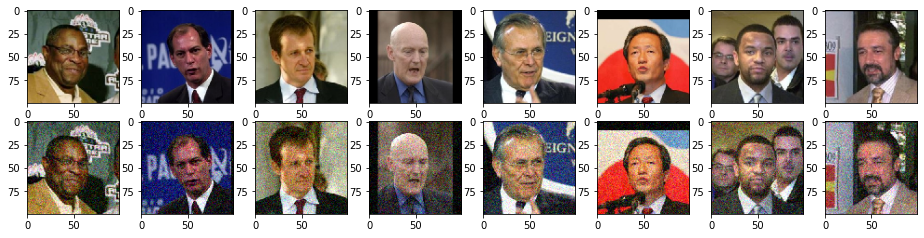

In [10]:
fig = plt.figure(figsize=(16, 16))
size = 8
for i in range(0, size):
  fig.add_subplot(size, size, i+1)
  plt.imshow(train_x[i], cmap="jet")
  fig.add_subplot(size, size, size+i+1)
  plt.imshow(x_train_noisy[i], cmap="jet")

# 4.2 Autoencoder

In [11]:
# กำหนด Encoder Architecture
Input_img = Input(shape=(100, 100, 3))
#encoding architecture
x1 = Conv2D(256, (3, 3), activation='relu', padding='same')(Input_img)
x2 = Conv2D(128, (3, 3), activation='relu', padding='same')(x1)
x2 = MaxPool2D( (2, 2))(x2)
encoded = Conv2D(64, (3, 3), activation='relu', padding='same')(x2)

# กำหนด Decoder Architecture
# decoding architecture
x3 = Conv2D(64, (3, 3), activation='relu', padding='same')(encoded)
x3 = UpSampling2D((2, 2))(x3)
x2 = Conv2D(128, (3, 3), activation='relu', padding='same')(x3)
x1 = Conv2D(256, (3, 3), activation='relu', padding='same')(x2)
decoded = Conv2D(3, (3, 3), padding='same')(x1)

# กำหนด optimizer setting
autoencoder = Model(Input_img, decoded) # เอา model มาใช้
autoencoder.compile(optimizer='adam', loss='mse') # -> loss ใช้ Mean Square Error
autoencoder.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 100, 100, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 100, 100, 256)     7168      
                                                                 
 conv2d_1 (Conv2D)           (None, 100, 100, 128)     295040    
                                                                 
 max_pooling2d (MaxPooling2D  (None, 50, 50, 128)      0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 50, 50, 64)        73792     
                                                                 
 conv2d_3 (Conv2D)           (None, 50, 50, 64)        36928     
                                                             

In [27]:
# กำหนด Training parameter
# epoch ทดลองอย่ํางน้อย 1 ค่า [ 2, 4, 8, 16 ]
# batch_size ทดลองอย่ํางน้อย 2 ค่า [16, 32, 64, 128]

epochs = 4
batch_size = 32 # ยิ่งสูง ยิ่งละเอียด ยิ่งรันนาน
early_stopper = EarlyStopping(monitor="val_loss", mode="min", patience=2)

# เริ่มการ Training
history = autoencoder.fit(x=x_train_noisy, # รูปที่เอามาเทรน
                          y=train_x,       # รูปที่ไม่มี noise
                          batch_size=batch_size,
                          epochs=epochs, 
                          shuffle=True, 
                          validation_data=(x_val_noisy, val_x), 
                          callbacks=[early_stopper])

Epoch 1/4
71/71 [==============================] - 1021s 14s/step - loss: 0.0273 - val_loss: 0.0142
Epoch 2/4
71/71 [==============================] - 689s 10s/step - loss: 0.0118 - val_loss: 0.0110
Epoch 3/4
71/71 [==============================] - 603s 9s/step - loss: 0.0107 - val_loss: 0.0105
Epoch 4/4
71/71 [==============================] - 625s 9s/step - loss: 0.0104 - val_loss: 0.0116


In [12]:
# ทดสอบ autoencoder model ด้วย validation
predictions = autoencoder.predict(x_val_noisy)
predictions.shape

2023-09-22 16:07:44.171718: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


KeyboardInterrupt: 

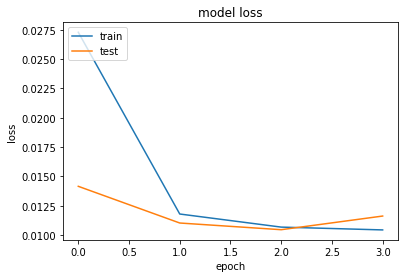

In [29]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

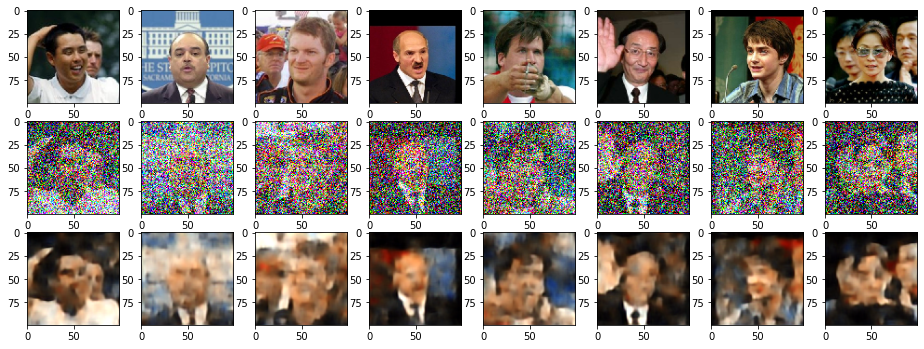

In [30]:
fig = plt.figure(figsize=(16, 16))
size = 8
for i in range(0, size):
  fig.add_subplot(size, size, i+1)
  plt.imshow(val_x[i])
  fig.add_subplot(size, size, size+i+1)
  plt.imshow(x_val_noisy[i])
  fig.add_subplot(size, size, size+size+i+1)
  plt.imshow(predictions[i])
  

# 4.3 Hyperparameter Tuning

In [13]:
# create_autoencoder function
def create_autoencoder(optimizer, learning_rate=0.01):
  Input_img = Input(shape=(100, 100, 3))
  # encoder layers
  #encoding architecture
  x1 = Conv2D(256, (3, 3), activation='relu', padding='same')(Input_img)
  x2 = Conv2D(128, (3, 3), activation='relu', padding='same')(x1)
  x2 = MaxPool2D( (2, 2))(x2)
  encoded = Conv2D(64, (3, 3), activation='relu', padding='same')(x2)
  # decoding architecture
  x3 = Conv2D(64, (3, 3), activation='relu', padding='same')(encoded)
  x3 = UpSampling2D((2, 2))(x3)
  x2 = Conv2D(128, (3, 3), activation='relu', padding='same')(x3)
  x1 = Conv2D(256, (3, 3), activation='relu', padding='same')(x2)
  decoded = Conv2D(3, (3, 3), padding='same')(x1)
  # construct the autoencoder model
  autoencoder = Model(Input_img, decoded)
  autoencoder.compile(optimizer=optimizer(learning_rate=learning_rate), loss='mean_squared_error',metrics=['mean_squared_error'])
  return autoencoder

In [14]:
# ประกําศ KERAS ตัวจัดกํารพํารํามิเตอร์ของ Model
model = KerasRegressor(build_fn=create_autoencoder, epochs=2, batch_size=16, verbose=0)

In [15]:
# กำหนด Grid Search parameters
optimizer = [Adadelta, Adam]
batch_size = [8, 16]
epochs = [100, 200]
learning_rate = [0.01]
param_grid = dict(batch_size=batch_size, epochs=epochs, optimizer=optimizer, learning_rate=learning_rate)

grid = GridSearchCV( estimator=model,
                      verbose= 10,
                      cv=2,
                      n_jobs=1,
                      param_grid = param_grid)

grid_result = grid.fit(x_train_noisy, train_x)
print('Best params: ',grid_result.best_params_)
print('Best score: ', grid_result.best_score_)
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']

Fitting 2 folds for each of 8 candidates, totalling 16 fits
[CV 1/2; 1/8] START batch_size=8, epochs=100, learning_rate=0.01, optimizer=<class 'keras.optimizer_v2.adadelta.Adadelta'>


KeyboardInterrupt: 

In [ ]:
for mean, stdev, param in zip(means, stds, params):
  print("%f (%f} with: %r" % (mean, stdev, param))

In [ ]:
# กำหนด Grid Search parameters
random_search = {'optimizer': ['Adadelta', 'Adam'],
                 'batch_size': list(np.linspace(8, 64, 5, dtype = int)),
                 'epochs': list(np.linspace(1, 10, 4, dtype = int))}

In [ ]:
grid_rand = RandomizedSearchCV( estimator=model,
                                verbose= 0,
                                cv=2
                                random_state = 10,
                                n_iter = 10,
                                n_jobs=1,
                                param_distributions=random_search)

In [ ]:
grid_rand_result = grid_rand.fit(x_train_noisy, train_x)
print('Best params: ',grid_rand_result.best_params_)
print('Best score: ', grid_rand_result.best_score_)
_means = grid_result.cv_results_['mean_test_score']
_stds = grid_result.cv_results_['std_test_score']
_params = grid_result.cv_results_['params']